In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape, RepeatVector
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [47]:
# Load and preprocess data
df = pd.read_csv('/teamspace/studios/this_studio/pamap2_HAR_raw.csv')

In [48]:
df=df.head(25000)

In [49]:
# Linear Interpolation and drop NANs
sensor_columns = [col for col in df.columns if col not in ['timestamp', 'activityID', 'activity_name']]
sensor_data = df[sensor_columns]
sensor_data = sensor_data.interpolate(method='linear', axis=0)
sensor_data = sensor_data.dropna()

In [50]:
# Feature Engineering
sensor_data['hand_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_hand_3D_acceleration_1']**2 +
    sensor_data['IMU_hand_3D_acceleration_2']**2 +
    sensor_data['IMU_hand_3D_acceleration_3']**2
)
sensor_data['chest_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_acceleration_1']**2 +
    sensor_data['IMU_chest_3D_acceleration_2']**2 +
    sensor_data['IMU_chest_3D_acceleration_3']**2
)
sensor_data['chest_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_gyroscope_1']**2 +
    sensor_data['IMU_chest_3D_gyroscope_2']**2 +
    sensor_data['IMU_chest_3D_gyroscope_3']**2
)
sensor_data['chest_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_magnetometer_1']**2 +
    sensor_data['IMU_chest_3D_magnetometer_2']**2 +
    sensor_data['IMU_chest_3D_magnetometer_3']**2
)
sensor_data['ankle_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_acceleration_1']**2 +
    sensor_data['IMU_ankle_3D_acceleration_2']**2 +
    sensor_data['IMU_ankle_3D_acceleration_3']**2
)
sensor_data['ankle_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_gyroscope_1']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_2']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_3']**2
)
sensor_data['ankle_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_magnetometer_1']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_2']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_3']**2
)

# Drop original columns
cols_to_drop = [
    'IMU_chest_3D_acceleration_1', 'IMU_chest_3D_acceleration_2', 'IMU_chest_3D_acceleration_3',
    'IMU_hand_3D_acceleration_1', 'IMU_hand_3D_acceleration_2', 'IMU_hand_3D_acceleration_3',
    'IMU_chest_3D_gyroscope_1', 'IMU_chest_3D_gyroscope_2', 'IMU_chest_3D_gyroscope_3',
    'IMU_hand_3D_gyroscope_1', 'IMU_hand_3D_gyroscope_2', 'IMU_hand_3D_gyroscope_3',
    'IMU_chest_3D_magnetometer_1', 'IMU_chest_3D_magnetometer_2', 'IMU_chest_3D_magnetometer_3',
    'IMU_ankle_3D_acceleration_1', 'IMU_ankle_3D_acceleration_2', 'IMU_ankle_3D_acceleration_3',
    'IMU_ankle_3D_gyroscope_1', 'IMU_ankle_3D_gyroscope_2', 'IMU_ankle_3D_gyroscope_3',
    'IMU_ankle_3D_magnetometer_1', 'IMU_ankle_3D_magnetometer_2', 'IMU_ankle_3D_magnetometer_3'
]
sensor_data = sensor_data.drop(cols_to_drop, axis=1)

In [51]:
# Min-Max Scaling
scaler = MinMaxScaler()
sensor_data_scaled = scaler.fit_transform(sensor_data)
sensor_data_scaled = pd.DataFrame(sensor_data_scaled, columns=sensor_data.columns)

In [52]:
# Reintroduce for splitting
sensor_data_scaled['timestamp'] = df['timestamp']
sensor_data_scaled['activityID'] = df['activityID']
sensor_data_scaled['activity_name'] = df['activity_name']

In [53]:
# Train-Test Split (80% train, 20% test)
train_threshold = df['timestamp'].quantile(0.8)
train_data = sensor_data_scaled[sensor_data_scaled['timestamp'] < train_threshold].drop(columns=['timestamp', 'activityID', 'activity_name'])
test_data = sensor_data_scaled[sensor_data_scaled['timestamp'] >= train_threshold].drop(columns=['timestamp', 'activityID', 'activity_name'])

In [54]:
# Create sequences for LSTM input
def create_sequences(data, seq_length=20):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data.iloc[i:i + seq_length].values)
    return np.array(sequences)

X_train = create_sequences(train_data)
X_test = create_sequences(test_data)

# LSTM AutoEncoder

In [55]:
class LSTMAutoencoder(Model):
    def __init__(self, input_shape):
        super(LSTMAutoencoder, self).__init__()
        self.encoder_lstm1 = LSTM(128, activation='relu', return_sequences=True)
        self.encoder_lstm2 = LSTM(64, activation='relu', return_sequences=False)
        self.decoder_repeat = RepeatVector(input_shape[0])
        self.decoder_lstm1 = LSTM(64, activation='relu', return_sequences=True)
        self.decoder_lstm2 = LSTM(128, activation='relu', return_sequences=True)
        self.decoder_dense = Dense(input_shape[1], activation='linear')
        self.reshape_layer = Reshape(input_shape)

    def call(self, inputs):
        encoded = self.encoder_lstm1(inputs)
        encoded = self.encoder_lstm2(encoded)
        decoded = self.decoder_repeat(encoded)
        decoded = self.decoder_lstm1(decoded)
        decoded = self.decoder_lstm2(decoded)
        decoded = self.decoder_dense(decoded)
        decoded = self.reshape_layer(decoded)
        return decoded

# Initialize and compile model
seq_length = X_train.shape[1]
num_features = X_train.shape[2]
autoencoder = LSTMAutoencoder((seq_length, num_features))
autoencoder.compile(optimizer='adam', loss='mse')

In [56]:
history=autoencoder.fit(X_train, X_train, epochs=20, batch_size=32)


Epoch 1/20


750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 0.0180
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - loss: 2.6452e-04
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - loss: 1.8751e-04
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - loss: 1.7634e-04
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - loss: 1.4086e-04
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 50ms/step - loss: 2.0138e-04
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - loss: 1.2641e-04
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - loss: 1.3123e-04
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - loss: 1.1279e-04
Epoch 10/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - loss: 1.1676e-04
Epoch 11/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - loss: 1.0948e-04
Epoch 12/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - loss: 1.1614e-04
Epoch 13/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - loss: 1.0054e-04
Epoch 14/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - loss:

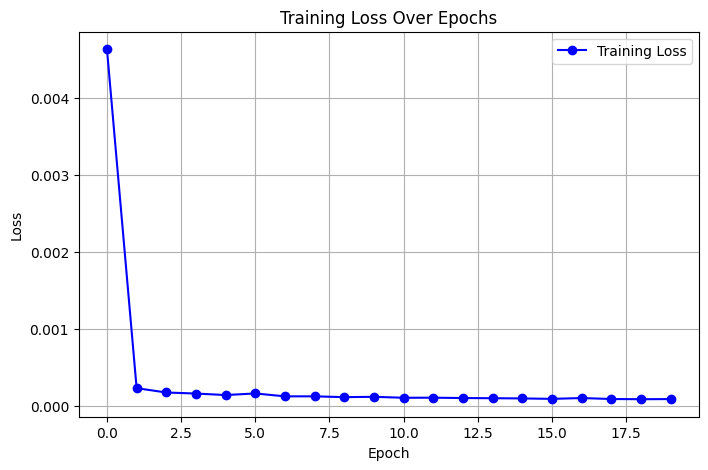

In [57]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

 87/187 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


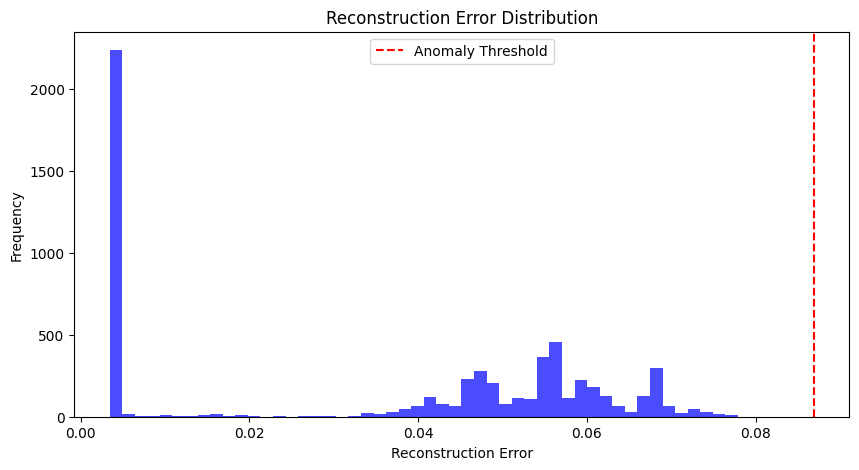

In [58]:
# Compute reconstruction error (Mean Squared Error per sequence)
reconstruction_errors = np.mean(np.abs(X_test - autoencoder.predict(X_test)), axis=(1,2))

# Plot histogram of reconstruction errors
plt.figure(figsize=(10,5))
plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='blue')
plt.axvline(np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors), color='red', linestyle='dashed', label="Anomaly Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()


In [59]:
def compute_unsupervised_rewards(X):
    reconstructed = autoencoder.predict(X)
    reconstruction_error = np.mean(np.abs(X - reconstructed), axis=2)
    threshold = np.percentile(reconstruction_error, 95, axis=0, keepdims=True)
    rewards = (reconstruction_error > threshold).astype(int)
    return rewards

unsupervised_rewards = compute_unsupervised_rewards(X_train)
unsupervised_rewards = np.expand_dims(unsupervised_rewards, axis=-1)

 81/750 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step

750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step


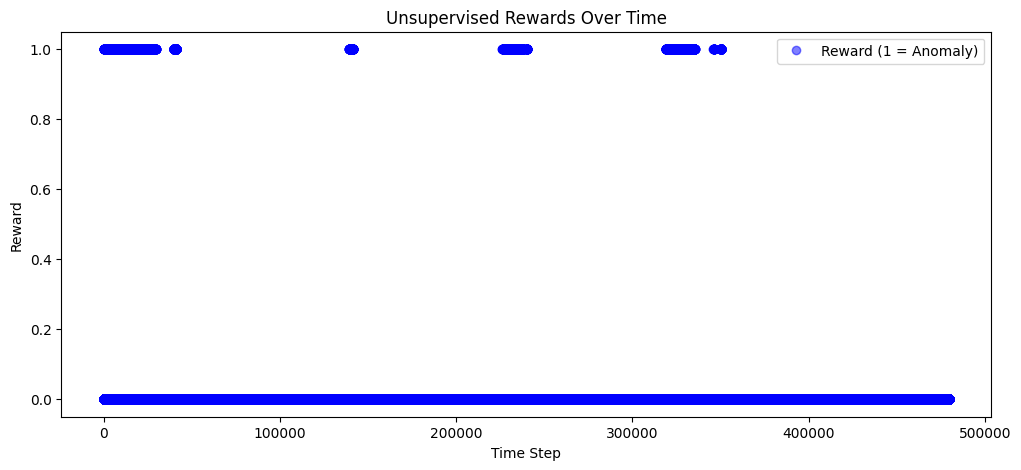

In [60]:
plt.figure(figsize=(12,5))
plt.plot(unsupervised_rewards.flatten(), 'bo', alpha=0.5, label="Reward (1 = Anomaly)")
plt.xlabel("Time Step")
plt.ylabel("Reward")
plt.title("Unsupervised Rewards Over Time")
plt.legend()
plt.show()


# PPO Agent

In [61]:
class PPOAgent(tf.keras.Model):
    def __init__(self, num_actions):
        super(PPOAgent, self).__init__()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(64, activation='relu')
        self.policy_logits = Dense(num_actions, activation=None)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.policy_logits(x)

In [62]:
num_actions = 2
ppo_model = PPOAgent(num_actions)

Epoch 1/10, Loss: 0.0276


Epoch 2/10, Loss: 0.0272
Epoch 3/10, Loss: 0.0268
Epoch 4/10, Loss: 0.0264
Epoch 5/10, Loss: 0.0261
Epoch 6/10, Loss: 0.0257
Epoch 7/10, Loss: 0.0253
Epoch 8/10, Loss: 0.0250
Epoch 9/10, Loss: 0.0246
Epoch 10/10, Loss: 0.0243


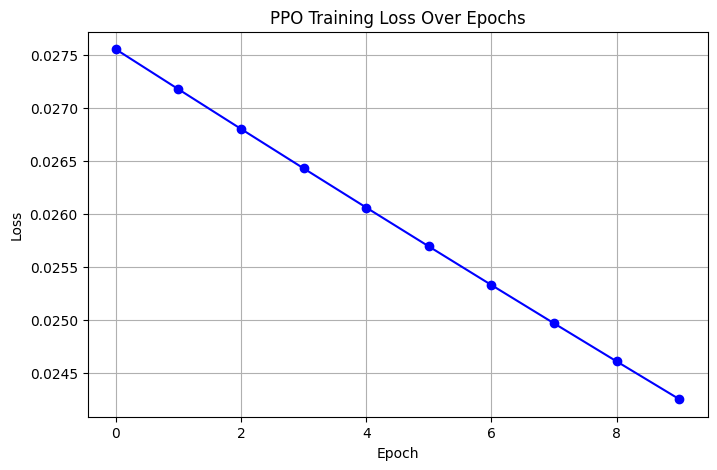

In [63]:
import matplotlib.pyplot as plt

# Store loss values from PPO training
ppo_losses = []

class PPOTrainer:
    def __init__(self, model, gamma=0.99, learning_rate=0.0001):
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.gamma = gamma

    def train(self, X, rewards, epochs=10):
        global ppo_losses  # Track losses globally
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                logits = self.model(X)
                policy_out = tf.nn.softmax(logits)
                rewards = np.where(rewards > 0, 1, 0).astype(int)
                rewards = rewards.reshape(rewards.shape[0], rewards.shape[1])
                action_probs = tf.reduce_sum(policy_out * tf.one_hot(rewards, depth=2), axis=-1)
                loss = -tf.reduce_mean(tf.math.log(action_probs + 1e-10) * tf.cast(rewards, tf.float32))
            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            
            ppo_losses.append(loss.numpy())  # Store loss
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy():.4f}")

ppo_trainer = PPOTrainer(ppo_model)
ppo_trainer.train(X_train, unsupervised_rewards, epochs=10)

# Plot PPO Loss
plt.figure(figsize=(8,5))
plt.plot(ppo_losses, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PPO Training Loss Over Epochs")
plt.grid()
plt.show()

187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


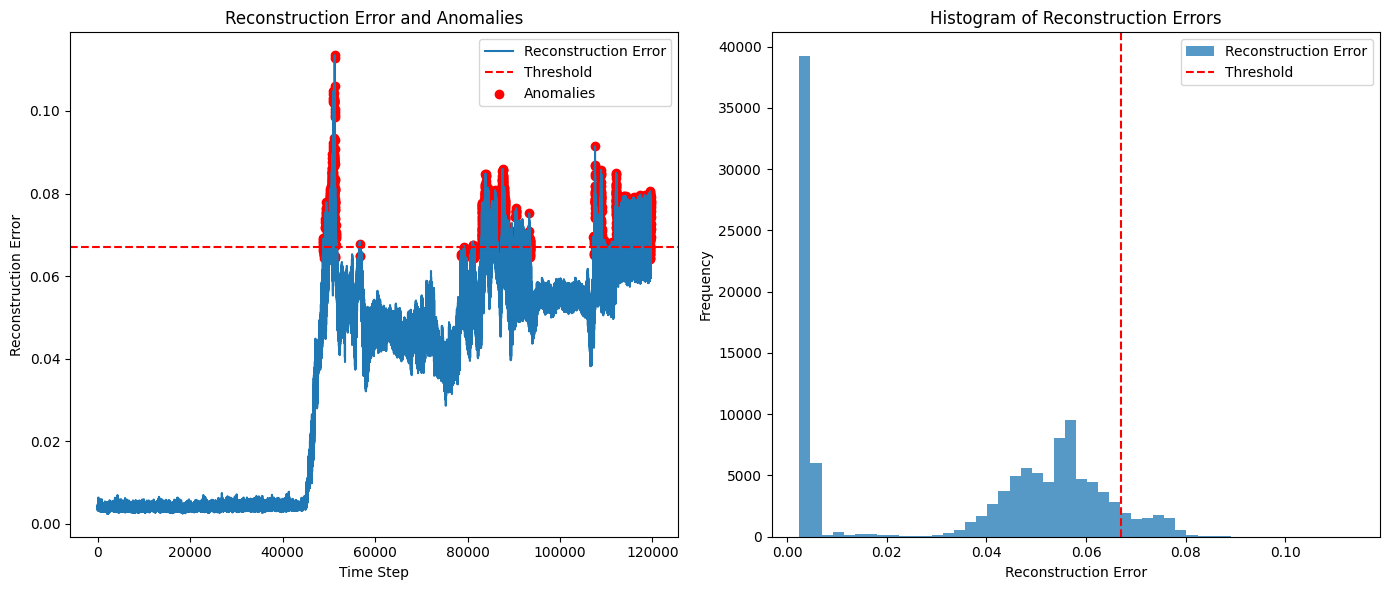

Total number of anomalies detected: 5980
Indices of anomalous points: [ 48799  48817  48818 ... 119588 119589 119590]
Reconstruction errors of anomalous points: [0.06816016 0.06647753 0.06784701 ... 0.07272857 0.0714205  0.06943735]


In [64]:
reconstructed_test = autoencoder.predict(X_test)
reconstruction_error_test = np.mean(np.abs(X_test - reconstructed_test), axis=2)

threshold = np.percentile(reconstruction_error_test, 95, axis=0, keepdims=True)

anomalies = (reconstruction_error_test > threshold).astype(int)
total_anomalies = np.sum(anomalies)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(reconstruction_error_test.flatten(), label='Reconstruction Error')
plt.axhline(y=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies.flatten() == 1), reconstruction_error_test.flatten()[anomalies.flatten() == 1], color='r', label='Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error and Anomalies')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(reconstruction_error_test.flatten(), bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(x=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total number of anomalies detected: {total_anomalies}")

anomalous_points = np.where(anomalies.flatten() == 1)[0]
print("Indices of anomalous points:", anomalous_points)
print("Reconstruction errors of anomalous points:", reconstruction_error_test.flatten()[anomalous_points])